This is the first tutorial on DSA! We'll recreate the third figure from the paper (except the Procrustes analysis). In doing so, we'll learn about how to structure our data matrices to fit into DSA, how to apply the DSA to data, and how to select various paramters for DSA.

In [2]:
# #install the packages that we haven't added in setup.py
! pip install matplotlib
! pip install scikit-learn
! pip install seaborn
! pip install pandas

In [3]:
from DSA import DSA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns
import pandas as pd

rng = np.random.default_rng(2023)


First, we need to define our models, which we construct as ordinary differential equations. There are 3 types of models:
* Bistable switch (nonlinear system)
* Line attractor (linear system)
* Point attractor (linear system)

The goal of this demonstration is to show that even the condition averaged trajectories sampled from these systems are the same, DSA can distinguish between the systems. 

How do we do this? Thanks to Galgali et al., (Nat. Neuro, 2023), we can construct three systems with different intrinsic dynamics that can be controlled to have the same condition averages. The process is a very simple feedback linearization scheme. We'll sample from the first system first and then use those condition averages to drive the latter two systems. 


In [4]:
#defining our models
def run_model1(cohs,params,time=100,cond_avgs=None,seeded=False):
    '''
    simple saddle model

    Parameters
    __________

    cohs : list or np.array
        list of the constant input drives (using -.1 and 0.1 as default)
    params : dict
        dictionary of the parameters in the model (a,b,c) and system evolution
        (dt, euler timesep size), (ntrials, number of sample trials),
        (sigma, noise variance)
    time : int 
        number of 'units to run', time / dt is the number of steps
    cond_avgs : np.ndarray or None
        condition average drive to control model
    seeded : bool
        if True, samples noise from a random generator with fixed seed
    ''' 
    a = params.get('a',-.6)
    b = params.get('b',2)
    c = params.get('c',-1)
    dt = params.get('dt',1)
    ntrials = params.get('ntrials',10)
    sigma = params.get('sigma',0)
    steps = int(time / dt)
    x = np.zeros((len(cohs),ntrials,steps,2))
    cohs = np.array(cohs)
    cohs = np.repeat(cohs[:,np.newaxis],ntrials,axis=1)
    input_optimized = np.zeros((len(cohs),ntrials,steps,2))
    for i in range(1,steps):
        dx = a*x[:,:,i-1,0]**3 + b*x[:,:,i-1,0] + cohs
        dy = c*x[:,:,i-1,1] + cohs
        dx = np.concatenate([dx[:,:,np.newaxis],dy[:,:,np.newaxis]],axis=2)
        if cond_avgs is not None:
            xavg = x[:,:,i-1].mean(axis=1)
            
            dx_avg = a*xavg[:,-1]**3 + b*xavg[:,-1] + cohs.mean(axis=1)
            dy_avg = c*xavg[:,-1] + cohs.mean(axis=1)
            dx_avg = np.concatenate([dx_avg[:,np.newaxis],dy_avg[:,np.newaxis]],axis=1)
            inp = (1/dt) * (cond_avgs[:,i] - xavg - dx_avg * dt)
            input_optimized[:,:,i] = np.repeat(inp[:,np.newaxis],ntrials,axis=1)
        else:
            input_optimized[:,:,i] = 0
        
        if seeded:
            rand = rng.normal(0,sigma,size=(len(cohs),ntrials,2))
        else:
            rand =  np.random.normal(0,sigma,size=(len(cohs),ntrials,2))
        x[:,:,i] = x[:,:,i-1] + dt * (dx + input_optimized[:,:,i] + rand)
               
    #xdot = [ax^3 + bx, cy]
    cond_avg = np.mean(x,axis=1)
    return x,cond_avg

def run_model2(cond_avgs,params,time=100):
    '''
    line attractor model - similar arguments as run_model
    '''
    l0 = params.get('l0',[1,1])
    l0 /= np.linalg.norm(l0)
    r0 = params.get('r0',[1,0])
    sigma = params.get('sigma',0)
    dt = params.get('dt',1)
    ntrials = params.get('ntrials',10)
    eval1 = params.get('eval1',-1)
    evals = np.diag([0,eval1])
    # Mrot = np.array([[0,-1],[1,0]])
    # r1 = Mrot @ l0
    r1 = l0
    R = np.array([r0,r1])
    L = np.linalg.inv(R)
    A = R @ evals @ L
    theta = np.radians(45)
    c, s = np.cos(theta), np.sin(theta)
    Mrot = np.array(((c, -s), (s, c)))
    A = Mrot @ A

    steps = int(time / dt)
    x = np.zeros((cond_avgs.shape[0],ntrials,steps,2))
    input_optimized = np.zeros((cond_avgs.shape[0],ntrials,steps,2))
    for i in range(1,steps):
        dx = np.einsum('ij,mkj->mki',A,x[:,:,i-1])
        #dx = A @ x[:,:,i-1]    
        # dx_avg = np.einsum('ij,mkj->mki',A,cond_avgs[:,i-1])
        xavg = x[:,:,i-1].mean(axis=1)
        dx_avg = A @ xavg #cond_avgs[:,i-1]
        inp = (1/dt) * (cond_avgs[:,i] - xavg - dx_avg * dt)
        input_optimized[:,:,i] = np.repeat(inp[:,np.newaxis],ntrials,axis=1)
        # diff = cond_avgs[:,i] - x[:,:,i-1].mean(axis=1)
        # opt_input = (diff - dx.mean(axis=1)) 
        # input_optimized[:,:,i-1] = np.repeat(opt_input[:,np.newaxis],ntrials,axis=1)
        x[:,:,i] = x[:,:,i-1] + dt*(dx + input_optimized[:,:,i] + 
                np.random.normal(0,sigma,size=(cond_avgs.shape[0],ntrials,2)))
    return x, input_optimized

def run_model3(cond_avgs,params,time=100):
    '''
    Point attractor model -- same argument structure as run_model2
    '''
    a1 = params.get('a1',-0.5) #eigenvalue 1
    a2 = params.get('a2',-1) #eigenvalue 2
    A = np.diag([-np.abs(a1),-np.abs(a2)]) #make sure they're negative
    sigma = params.get('sigma',0)
    dt = params.get('dt',1)
    steps = int(time / dt)
    ntrials = params.get('ntrials',10)
    x = np.zeros((cond_avgs.shape[0],ntrials,steps,2))
    input_optimized = np.zeros((cond_avgs.shape[0],ntrials,steps,2))
    for i in range(1,steps):
        dx = np.einsum('ij,mkj->mki',A,x[:,:,i-1])
        #dx = A @ x[:,:,i-1] -- is the basic computation
        xavg = x[:,:,i-1].mean(axis=1)
        dx_avg = A @ xavg #cond_avgs[:,i-1]
        # dx_avg = np.einsum('ij,mj->mi',A,cond_avgs[:,i-1])
        inp = (1/dt) * (cond_avgs[:,i] - xavg - dx_avg * dt)
        input_optimized[:,:,i] = np.repeat(inp[:,np.newaxis],ntrials,axis=1)      
          # diff = cond_avgs[:,i] - x[:,:,i-1].mean(axis=1)
        # opt_input = (diff - dx.mean(axis=1)) 
        # input_optimized[:,:,i-1] = np.repeat(opt_input[:,np.newaxis],ntrials,axis=1)
        x[:,:,i] = x[:,:,i-1] + dt*(dx + input_optimized[:,:,i] + 
               np.random.normal(0,sigma,size=(cond_avgs.shape[0],ntrials,2)))
    return x, input_optimized

(2, 20, 10000, 2) (2, 10000, 2)
(2, 20, 10000, 2) (2, 10000, 2)
(2, 20, 10000, 2) (2, 10000, 2)


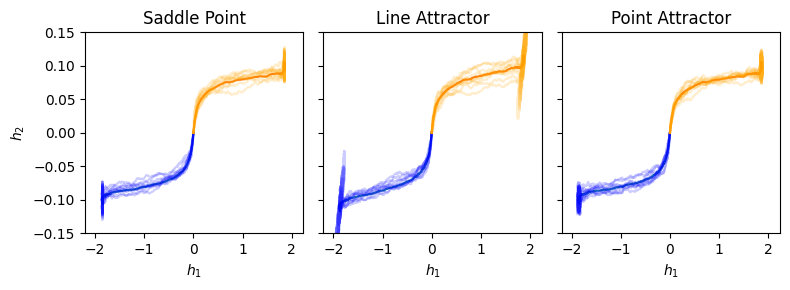

In [5]:
#let's visualize a sample from each 
x1,cond_avg = run_model1([-.1,.1],dict(dt=0.01,sigma=0.1,ntrials=20))
print(x1.shape,cond_avg.shape)

x2,input_optimized2 = run_model2(cond_avg,dict(dt=0.01,sigma=0.1,ntrials=20))
cond_avg2 = x2.mean(axis=1)
print(x2.shape,cond_avg2.shape)

x3,input_optimized3 = run_model3(cond_avg,dict(dt=0.01,sigma=0.1,ntrials=20))
cond_avg3 = x3.mean(axis=1)
print(x3.shape,cond_avg3.shape)

fig,ax = plt.subplots(1,3,figsize=(8,3),sharex=True,sharey=True)
for i in range(x1.shape[0]):
    for k, cavg in enumerate([cond_avg,cond_avg2,cond_avg3]):
        ax[k].plot(cavg[i,:,0],cavg[i,:,1])
    for j in range(x1.shape[1]):
        if j == 10:
            break
        for k, x in enumerate([x1,x2,x3]):
            ax[k].plot(x[i,j,:,0],x[i,j,:,1],c="orange" if i else "blue", alpha = 0.2)

for i in range(3):
    ax[i].set_ylim(-0.15,0.15)
    ax[i].set_xlabel(r"$h_1$")
ax[0].set_ylabel(r"$h_2$")

ax[0].set_title("Saddle Point")
ax[1].set_title("Line Attractor")
ax[2].set_title("Point Attractor")
plt.tight_layout()



In [6]:
#define the parameters for our samples and our dmd
nmodels = 4 #3 x nmodels total
sigma = 0.05 #trajectory noise
ntrials = 100 #number of trajectories per model
dt = 0.01 #timestep simulated in the odes --don't make this too small


#if you want to make the task harder, you can change these paramters around!
#vary params for model 1
a = np.random.uniform(-5,-4,size=nmodels)  
b = np.random.uniform(4,5,size=nmodels)
c = np.random.uniform(-4,-3,size=nmodels)

#vary params for model 2
eval1 = np.random.uniform(-2,-3,size=nmodels)

#vary params for model 3
a1 = np.random.uniform(-4,-5,size=nmodels)
a2 = np.random.uniform(-8,-9,size=nmodels)


Next let's sample the data. Depending on how you set your parameters, such as the number of models, this may take awhile. We'll run them alternating model type, so the models 2 and 3 aren't fitted only only a single condition-averaged trajectory from model 1

In [7]:
#some code that's relevant for processing our data
def flatten_x(x1):
    #this will flatten the first 2 dimensions (conditions, trials) to 1 dimension
    return x1.reshape(x1.shape[0]*x1.shape[1],x1.shape[2],x1.shape[3])

models = [[],[],[]]
model_names = ['bistable'] * nmodels + ['line attractor'] * nmodels + ['point attractor'] * nmodels

for i in range(nmodels):    
    x1,cond_avg = run_model1([-.1,.1],dict(dt=dt,sigma=sigma,ntrials=ntrials,a=a[i],b=b[i],c=c[i]))  
    #x has shape conditions x trials x time x dimension
    models[0].append(flatten_x(x1))

    x2,input_optimized = run_model2(cond_avg,dict(dt=dt,sigma=sigma,ntrials=ntrials,eval1=eval1[i]))
    models[1].append(flatten_x(x2))

    x3,input_optimized = run_model3(cond_avg,dict(dt=dt,sigma=sigma,ntrials=ntrials,a1=a1[i],a2=a2[i]))
    models[2].append(flatten_x(x3))

models = [x for mtype in models for x in mtype] #list the models by type (bistable,...,line,...,point,...)

In [12]:
#dmd parameters, all others are default for now.
n_delays = 50
delay_interval = 20
rank = 30
device = 'cpu' #change this if you have a GPU! Otherwise it will be slow

#playing around with optimization here, we don't necessarily need the metric to converge to 
#get good clustering!
dsa = DSA.DSA(models,n_delays=n_delays,rank=rank,delay_interval=delay_interval,verbose=True,device=device,iters=1000,lr=1e-2)
similarities = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...


SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix compute

Let's first visualize this as a heatmap. We should see a block structure corresponding to the different types of models.

<Axes: >

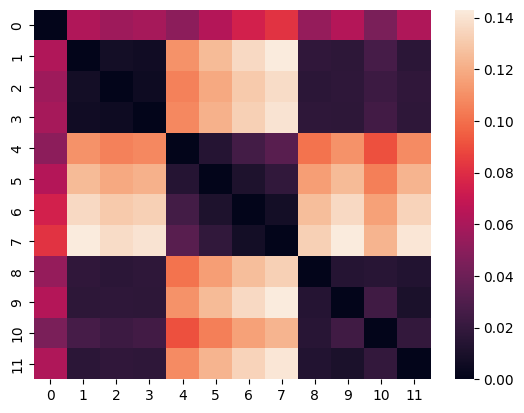

In [13]:
sns.heatmap(similarities)

Excellent! We should see a block structure here. Let's reduce the dimensionality with MDS and make sure the clusters appear. Note that they might not be as evident with a small number of models--in the original paper, we used 100 models for each type, which really allowed for some strong separation between each network. It's possible that the clustering will be weaker in the smaller dataset setting.

/Users/as15635/miniforge3/envs/ComparingNetworks/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


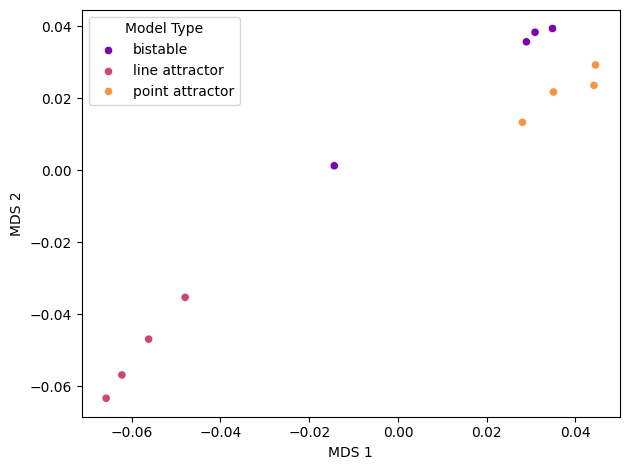

In [14]:
df = pd.DataFrame()
df['Model Type'] = model_names
reduced = MDS(dissimilarity='precomputed').fit_transform(similarities)
df["0"] = reduced[:,0] 
df["1"] = reduced[:,1]

palette = 'plasma'
sns.scatterplot(data=df,x="0",y="1",hue="Model Type",palette=palette)
plt.xlabel(f"MDS 1")
plt.ylabel(f"MDS 2")
plt.tight_layout()


# Dealing with Memory Issues involved in Many Comparisons

The current DSA object might not be very good at is performing comparisons on many many models (think hundreds to thousands). This is because the current object would require saving all of the data simultaneously, fitting each DMD in series, and then comparing each DMD pairwise. That would take a lot of memory! Fortunately, we can design a different approach in which we utilize the two main objects in the DSA class iteratively: 
* DMD: fits the DMD matrix to the data
* SimilarityTransformDist: compares two DMD matrices, returning a similarity score

With these in series, we can iteratively compute the DMD matrices, and save only the relevant feature: DMD.A_v.numpy(), the DMD matrix. This will allow us to throw away our data for each model (or stream them in one at a time), thereby allowing us to fit many more models without having to put it all into one class. Then, we can compute our DSA's pairwise to achieve the final result. 

For the sake of readability here, we'll only display the standard looped version, but for added computational boost we can add in parallel processing for each DMD computation

In [22]:
from DSA.dmd import DMD
from DSA.simdist import SimilarityTransformDist

nmodels = 5 #3*nmodels total, turn this up as high as you want
sigma = 0.05

ntrials = 300
dt = 0.01
downsample = 20
n_delays = 50
rank = 30

#vary params for model 1
a = np.random.uniform(-5,-3,size=nmodels)  
b = np.random.uniform(4,7,size=nmodels)
c = np.random.uniform(-4,-2,size=nmodels)

#vary params for model 2
eval1 = np.random.uniform(-1,-3,size=nmodels)

#vary params for model 3
a1 = np.random.uniform(-2,-5,size=nmodels)
a2 = np.random.uniform(-8,-10,size=nmodels)

def fit_dmd(x,n_delays,rank,delay_interval):
    x = flatten_x(x)
    #notice how we initialize the dmd separately here, rather than the DSA object itself
    dmd = DMD(x,n_delays=n_delays,rank=rank,delay_interval=delay_interval,device='cpu')
    print(dmd.A_v)
    # dmd.fit(send_to_cpu=True)
    return dmd.A_v.numpy()


In [23]:
model_types = []
models = []
for i in range(nmodels):    
    print(i)
    x1,cond_avg = run_model1([-.1,.1],dict(dt=dt,sigma=sigma,ntrials=ntrials,a=a[i],b=b[i],c=c[i]))

    #x has shape conditions x trials x time x dimension
#     x1 = x1[:,:,::downsample] #here we're downsampling instead of using delay_interval in the dmd class
    dmd1 = fit_dmd(x1,n_delays,rank,downsample)
    models.append(dmd1)
    model_types.append('bistable')

    x2,input_optimized = run_model2(cond_avg,dict(dt=dt,sigma=sigma,ntrials=ntrials,eval1=eval1[i]))
#     x2 = x2[:,:,::downsample]
    dmd2 = fit_dmd(x2,n_delays,rank,downsample)
    models.append(dmd2)
    model_types.append('line attractor')

    x3,input_optimized = run_model3(cond_avg,dict(dt=dt,sigma=sigma,ntrials=ntrials,a1=a1[i],a2=a2[i]))
#     x3 = x3[:,:,::downsample]
    dmd3 = fit_dmd(x3,n_delays,rank,downsample)
    models.append(dmd3)
    model_types.append('point attractor')


0
None


AttributeError: 'NoneType' object has no attribute 'numpy'

In [12]:
nmodels_tot = len(models) #should be 3*nmodels

sims_dmd = np.zeros((nmodels_tot,nmodels_tot))
sims_mtype = np.zeros((nmodels_tot,nmodels_tot))
#notice how we are initializing the similarity transform separately here
comparison_dmd = SimilarityTransformDist(device='cuda',iters=2000,lr=1e-3)

for i,mi in enumerate(models):
    for j,mj in enumerate(models):
        smtype = int(model_types[i] == model_types[j])
        sims_mtype[i,j] = sims_mtype[j,i] = smtype
        if i == j:
            sims_mtype[i,i] = 2
        if j < i:
            continue
        sdmd = comparison_dmd.fit_score(mi,mj)
        print(i,j,sdmd)

        sims_dmd[i,j] = sims_dmd[j,i] = sdmd


0 0 0.0
0 1 0.019186703
0 2 0.009880952
0 3 0.013784869
0 4 0.018270064
0 5 0.015367441
0 6 0.010148779
0 7 0.016282732
0 8 0.01389684
0 9 0.010658683
0 10 0.016471991
0 11 0.015901202
0 12 0.011905524
0 13 0.016815798
0 14 0.014998405
1 1 0
1 2 0.021556804
1 3 0.016072713
1 4 0.0036702405
1 5 0.018898722
1 6 0.018109493
1 7 0.008407826
1 8 0.021166135
1 9 0.017249746
1 10 0.0080381455
1 11 0.019543765
1 12 0.016486458
1 13 0.0062052174
1 14 0.020368177
2 2 0
2 3 0.0107088955
2 4 0.02125326
2 5 0.015990915
2 6 0.01086911
2 7 0.021016344
2 8 0.011367685
2 9 0.009826509
2 10 0.02084833
2 11 0.014214892
2 12 0.0102015
2 13 0.020632776
2 14 0.011294038
3 3 0.0
3 4 0.016205672
3 5 0.017034156
3 6 0.008126642
3 7 0.017564781
3 8 0.010036567
3 9 0.005970233
3 10 0.016932372
3 11 0.013024486
3 12 0.004991472
3 13 0.016377633
3 14 0.0110647725
4 4 0
4 5 0.018426005
4 6 0.017557994
4 7 0.0063851164
4 8 0.020856904
4 9 0.016737634
4 10 0.005545816
4 11 0.01925493
4 12 0.01626808
4 13 0.005015298


/om2/user/ostrow/anaconda/envs/dmrsa/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


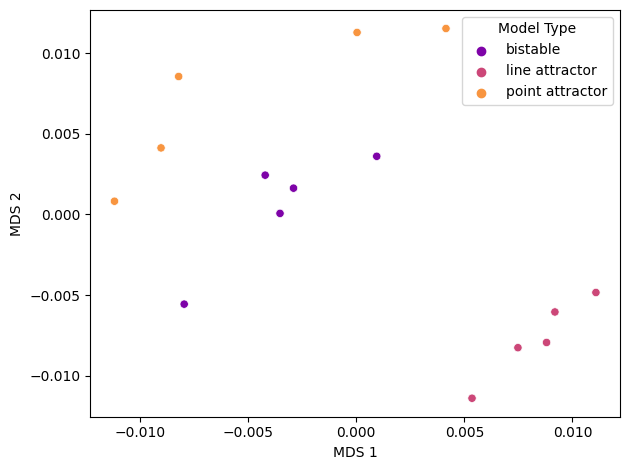

In [15]:
df = pd.DataFrame()
df['Model Type'] = model_types
lowd_embedding = MDS(dissimilarity='precomputed').fit_transform(sims_dmd)
df[f"DMD:0"] = lowd_embedding[:,0] 
df[f"DMD:1"] = lowd_embedding[:,1]
    

fig,ax = plt.subplots(1,1,sharex=True,sharey=True)
sns.scatterplot(data=df,x=f"DMD:0",y=f"DMD:1",hue="Model Type",ax=ax,palette=palette)
ax.set_xlabel(f"MDS 1")
ax.set_ylabel(f"MDS 2")
plt.tight_layout()